## Tutorial - 0: Continuous Forward Schrodinger

Welcome to our tutorial on the effect of differing non-linearities in Physics-Informed Neural Networks (PINNs) using `PyTorch Lightning` and the new package, **`pinnstorch`**! This guide aims to introduce you to the integration of deep learning and scientific computing via PINNs, which embed physical laws into neural network training.
### UPDATE TO SUIT MY CHANGES
#### Overview:

- **Mesh Generation and Sampling:** Understanding how to create and use meshes for training PINNs, crucial for defining the domain of our problem.
- **Neural Network Model with PINNs:** How to build and structure a neural network for physical law integration.
- **Physical Laws in Neural Networks:** Detailing the implementation of differential equations within the network using `pde_fn` and `output_fn`.
- **Training and Validation:** Utilizing PyTorch Lightning’s Trainer to train our model, including defining the training data, initial conditions, and handling boundary conditions.
- **Results Visualization:** Saving and analyzing the outcomes of your PINN models.

#### Install Libraries


In [1]:
!pip install lightning

In [2]:
from typing import Dict

import torch
import numpy as np
import lightning.pytorch as pl

import pinnstorch

### Define Mesh

Physics-Informed Neural Networks (PINNs) require a discretized domain (mesh) over which the physical equations are solved. In `pinnstorch`, there are primarily two approaches to define this mesh:


- **Defining Point Clouds:** This method involves directly utilizing spatio-temporal data (e.g., from experiments or other simulations) to create a mesh using `pinnstorch.data.PointCloud`.


**Note:** It's crucial to format the spatial and temporal domain dimensions correctly. Specifically:

- **Spatial Domain:** Each axis should be structured in the shape of $(N \times 1)$, where $N$ represents the number of spatial points.
- **Time Domain:** This should be formatted as $(T \times 1)$, where $T$ indicates the number of time steps.
- **Solution Data:** Each solution variable (e.g., temperature, velocity) should be in the shape of $(N \times T)$, aligning with the spatial and temporal points.

In [3]:
def read_data_fn(root_path):
    """Read and preprocess data from the specified root path.

    :param root_path: The root directory containing the data.
    :return: Processed data will be used in PointCloud class.
    """

    data = pinnstorch.utils.load_data(root_path, "NLS.mat")

    x = data["x"].T  # N x 1
    t = data["tt"].T  # T x 1

    exact = data["uu"]
    exact_u = np.real(exact) # N x T
    exact_v = np.imag(exact) # N x T
    exact_h = np.sqrt(exact_u**2 + exact_v**2) # N x T

    print(f" x has {x.shape} shape with min: {x.min()}, max: {x.max()}")
    print(f" t has {t.shape} shape with min: {t.min()}, max: {t.max()}")
    print(f"  exact_u {exact_u.shape} shape with min: {exact_u.min()}, max: {exact_u.max()}")
    print(f" exact_v {exact_v.shape} shape with min: {exact_v.min()}, max: {exact_v.max()}")
    print(f" exact_h  {exact_h.shape} shape with min: {exact_h.min()}, max: {exact_h.max()}")



    return pinnstorch.data.PointCloudData(
            spatial=[x], time=[t], solution={"u": exact_u, "v": exact_v, "h": exact_h}
    )

Now, mesh can be initalize with using the function and the directory to the folder of data.

In [4]:
mesh = pinnstorch.data.PointCloud(root_dir='./data',
                                  read_data_fn=read_data_fn)

 x has (256, 1) shape with min: -5.0, max: 4.9609375
 t has (201, 1) shape with min: 0.0, max: 1.5707963267948966
  exact_u (256, 201) shape with min: -3.932425448799453, max: 2.1998422786360754
 exact_v (256, 201) shape with min: -3.4523031901896957, max: 2.754265786698505
 exact_h  (256, 201) shape with min: 0.015981892796576278, max: 3.9987582390710266


### Define Train datasets

For solving Schrodinger PDE, we have:
- Initial condition
- Periodic boundary condition
- Collection points for the PDE.

#### Initial Condition

Let's start with initial condition of the Schrodinger.
$$ u(0, x) = 2 \text{sech}(x) $$
$$ v(0, x) = 0 $$

For defining initial condition, again we have two options.

- **Sample from the data.**
- **Defining a function for calculating initial condition.**

##### Set number of samples

In [5]:
NO = 50

The input of `initial_fun` should be the same as spatial domain of the problem.

In [6]:
def initial_fun(x):
    return {'u': 2*1/np.cosh(x), 'v': np.zeros_like(x)}

In [7]:
in_c = pinnstorch.data.InitialCondition(mesh = mesh,
                                        num_sample = NO,
                                        initial_fun = initial_fun,
                                        solution = ['u', 'v'])

The `solution` attribute in `pinnstorch.data.InitialCondition` specifies the solutions (`u` and `v` in our case) to be sampled for initial conditions.

#### Periodic Boundary Condition

The `pinnstorch.data.PeriodicBoundaryCondition` is used to sample periodic points from the upper and lower bounds of the spatial domain (mesh). The `derivative_order` parameter specifies the order of the derivative to be matched at these boundaries. In our case, for the Schrödinger equation, both the function and its first spatial derivative should match at the boundaries, hence `derivative_order = 1`.


$$ u(t,-5) = u(t, 5), $$
$$ v(t,-5) = v(t, 5), $$
$$ u_x(t,-5) = u_x(t, 5),$$
$$ v_x(t,-5) = v_x(t, 5) $$

In [8]:
N_b = 50
pe_b = pinnstorch.data.PeriodicBoundaryCondition(mesh = mesh,
                                                 num_sample = N_b,
                                                 derivative_order = 1,
                                                 solution = ['u', 'v'])

#### Mesh Sampler for collection points and solutions

In our problem, the partial differential equations (PDEs) governing the dynamics are given by:

$$ f_u := u_t + 0.5v_{xx} + v(u^2 +v^2),$$
$$ f_v := v_t + 0.5u_{xx} + u(u^2 +v^2) $$

To find the solutions to these PDEs using a neural network, we must sample points from the domain at which the network will be trained to satisfy these equations. This sampling process is crucial for training our PINN. We utilize the `pinnstorch.data.MeshSampler` for this purpose, specifying the following:

- **Number of Sample Points (N_f):** We choose to sample 20,000 points from the domain. This number is a balance between computational efficiency and the need for a sufficiently dense sampling to capture the dynamics of the PDEs.
- **Mesh (mesh):** This parameter defines the spatial-temporal domain from which the points will be sampled.
- **Collection Points:** We define `['f_u', 'f_v']` as the targets for our collection points. These are not direct outputs from the neural network but are derived from the network outputs and their derivatives (We will define `pde_fn` function later). The PINN will be trained such that these expressions tend towards zero, aligning with the PDE constraints.

Here's the code to implement this sampler:

In [9]:
N_f = 20000
me_s = pinnstorch.data.MeshSampler(mesh = mesh,
                                   num_sample = N_f,
                                   collection_points = ['f_v', 'f_u'])

### Define Validation dataset

For validation, we sample all points from the mesh to evaluate our model comprehensively. Model will be validated for solutions of `u`, `v`, and `h`.

**Note:** If `num_sample` is not specified, the sampler will use the entire mesh for data sampling.

In [10]:
val_s = pinnstorch.data.MeshSampler(mesh = mesh,
                                    solution = ['u', 'v', 'h'])

### Define `pde_fn` and `output_fn` functions

Now, we define `pde_fn` and `output_fn`.
- **`output_fn`:** is applied to the network's output, adding any necessary post-processing computations. For example, in our case, `h(x,t) = u(x,t)**2 + v(x,t)**2`, thus, we define this equation in `output_fn`.
- **`pde_fn`:** formulates the PDE constraints, which will be used by the `MeshSampler` to compute the loss at the collection points.

#### `output_fn` function

**Note:** `output_fn` should always have these inputs:
- **Outputs:** It is output of the network. In our case, this dictionary should have two output: `u` and `v`.
- **Spatial domains:** These are the spatial domain variables. In our case, because our problem has 1-D spatial domain, the input just have `x`. For example, if we had 2-D space, we need another input for that dimention. For example, the inputs from `(outputs, x, t)` will be changed to `(outputs, x, y, t)`.
- **Time domin:** The last input of `output_fn` function always should be time.

In [11]:
def output_fn(outputs: Dict[str, torch.Tensor],
              x: torch.Tensor,
              t: torch.Tensor):
    """Define `output_fn` function that will be applied to outputs of net."""

    outputs["h"] = torch.sqrt(outputs["u"] ** 2 + outputs["v"] ** 2)

    return outputs

#### `pde_fn` function

The inputs are similar to `output_fn`. Only if we have extra variables for training (i.g. in inverse problems), we should add input at the end of inputs. For example, `(outputs, x, t)` will be `(outputs, x, t, extra_variable)`. `extra_variable` is always a dictionary.

In [12]:
def pde_fn(outputs: Dict[str, torch.Tensor],
           x: torch.Tensor,
           t: torch.Tensor):
    """Define the partial differential equations (PDEs)."""
    u_x, u_t = pinnstorch.utils.gradient(outputs["u"], [x, t])
    v_x, v_t = pinnstorch.utils.gradient(outputs["v"], [x, t])

    u_xx = pinnstorch.utils.gradient(u_x, x)[0]
    v_xx = pinnstorch.utils.gradient(v_x, x)[0]

    outputs["f_u"] = u_t + 0.5 * v_xx + (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["v"]
    outputs["f_v"] = v_t - 0.5 * u_xx - (outputs["u"] ** 2 + outputs["v"] ** 2) * outputs["u"]

    return outputs

### Define PINNDataModule and PINNModule

To integrate with Lightning, we utilize two specialized modules:

- `PINNDataModule` (inherited from `LightningDataModule`) manages data.
- `PINNModule` (derived from `LightningModule`) handles the model, compilation, and various enhancements like AMP.

#### Define `PINNDataModule`
Here, we define collection points, initial condition, and preiodic boundary condition as training datasets, and also, we set validation set. `PINNDataModule` is used for defining training, validation, prediction, and test datasets.

In [13]:
train_datasets = [me_s, in_c, pe_b]
val_dataset = val_s
datamodule = pinnstorch.data.PINNDataModule(train_datasets = [me_s, in_c, pe_b],
                                            val_dataset = val_dataset,
                                            pred_dataset = val_s)

## DEFINING MODELS

In [14]:
import time

Define the layers and epochs of your model below

In [15]:
layers = [2, 100, 100, 100, 100, 2]
num_epochs = 100

### Activations and Initializers


##### DEFAULT

The default activation for PINNS is typically the `Hyperbolic Tangent` also known as `Tanh`.

![](https://www.aitude.com/wp-content/uploads/2020/08/507x279xtanh-graph-aitude-1024x564.png.pagespeed.ic.W1m7DEvoG3.png)


In [16]:
net_tanh = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="TANH",  # use registry
                            activation_kwargs={},  # extra params
                            initializer="XAVIER_UNIFORM",  # use registry
                            initializer_kwargs={},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [17]:
model = pinnstorch.models.PINNModule(net = net_tanh,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [18]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = num_epochs)
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:377: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:
C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten

Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.54it/s, v_num=84, train/loss_step=1.360]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:
C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten


Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, v_num=84, train/loss_step=0.642, val/loss=1.190, val/error_u=0.871, val/error_v=0.966, val/error_h=0.813, val/loss_best=1.190, train/loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=84, train/loss_step=1.080, val/loss=1.410, val/error_u=1.010, val/error_v=1.110, val/error_h=0.820, val/loss_best=1.190, train/loss_epoch=0.642]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 36.57it/s, v_num=84, train/loss_step=0.784, val/loss=1.240, val/error_u=0.867, val/error_v=1.150, val/error_h=0.762, val/loss_best=1.190, train/loss_epoch=1.080]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s, v_num=84, train/loss_step=0.254, val/loss=0.898, val/error_u=0.797, val/error_v=1.030, val/error_h=0.574, val/loss_best=0.898, train/loss_epoch=0.254]


In [19]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 10.301101922988892s


In [20]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.5735777020454407     │
│        val/error_u        │    0.7970353960990906     │
│        val/error_v        │    1.0268865823745728     │
│         val/loss          │    0.8982515931129456     │
│       val/loss_best       │    0.8982515931129456     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.8982515931129456,
  'val/error_u': 0.7970353960990906,
  'val/error_v': 1.0268865823745728,
  'val/error_h': 0.5735777020454407,
  'val/loss_best': 0.8982515931129456}]

In [186]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


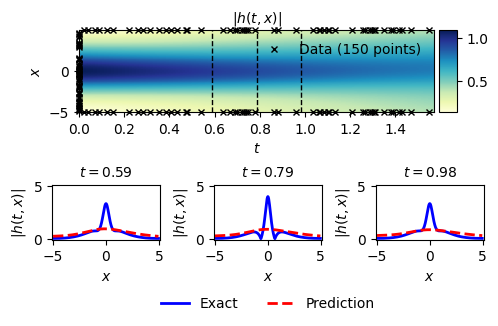

In [22]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/1_tanh')

##### ReLu

The `Rectified Linear Unit` also known as `Relu` is another common activation. This activation is typically not utilized with PINNs

![](https://www.aitude.com/wp-content/uploads/2020/08/relu-activation.png)


In [23]:
net_relu = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="RELU",  # use registry
                            activation_kwargs={},  # extra params
                            initializer="XAVIER_UNIFORM",  # use registry
                            initializer_kwargs={},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [24]:
model = pinnstorch.models.PINNModule(net = net_relu,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [25]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs = num_epochs)
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modu

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, v_num=85, train/loss_step=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  6.30it/s, v_num=85, train/loss_step=0.970, val/loss=1.290, val/error_u=0.911, val/error_v=0.959, val/error_h=0.864, val/loss_best=1.290, train/loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, v_num=85, train/loss_step=0.803, val/loss=1.210, val/error_u=0.872, val/error_v=0.958, val/error_h=0.832, val/loss_best=1.210, train/loss_epoch=0.970]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 28.60it/s, v_num=85, train/loss_step=0.699, val/loss=1.160, val/error_u=0.856, val/error_v=0.961, val/error_h=0.802, val/loss_best=1.160, train/loss_epoch=0.803]
Validation: |     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s, v_num=85, train/loss_step=0.198, val/loss=0.908, val/error_u=0.799, val/error_v=1.040, val/error_h=0.575, val/loss_best=0.908, train/loss_epoch=0.198]


In [26]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 8.608314990997314s


In [27]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.5754933953285217     │
│        val/error_u        │    0.7989136576652527     │
│        val/error_v        │    1.0376617908477783     │
│         val/loss          │    0.9082374572753906     │
│       val/loss_best       │    0.9077095985412598     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.9082374572753906,
  'val/error_u': 0.7989136576652527,
  'val/error_v': 1.0376617908477783,
  'val/error_h': 0.5754933953285217,
  'val/loss_best': 0.9077095985412598}]

In [28]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.95it/s] 


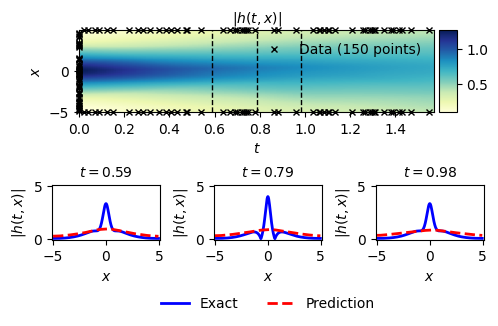

In [29]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/2_relu')

##### SIREN

`SIREN` architectures utilize `sinusoidal` activation functions. These activations require tuning of the frequency parameter `omega` as well as a custom initialisation for stability.

Try different values of `omega` and see how it affects the training.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*xGr5o0m1OPsDtmtGas4rUg.png)

In [30]:
net_sine = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="SINE",  # use registry
                            activation_kwargs={'omega':5},  # extra params
                            initializer="SIREN",  # use registry
                            initializer_kwargs={'omega':5},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [31]:
model = pinnstorch.models.PINNModule(net = net_sine,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [32]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs = num_epochs)
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modu

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.85it/s, v_num=86, train/loss_step=2.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.13it/s, v_num=86, train/loss_step=1.120, val/loss=1.330, val/error_u=1.020, val/error_v=0.979, val/error_h=0.806, val/loss_best=1.330, train/loss_epoch=2.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, v_num=86, train/loss_step=0.748, val/loss=1.160, val/error_u=0.909, val/error_v=0.977, val/error_h=0.762, val/loss_best=1.160, train/loss_epoch=1.120]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s, v_num=86, train/loss_step=0.498, val/loss=0.994, val/error_u=0.806, val/error_v=0.962, val/error_h=0.699, val/loss_best=0.994, train/loss_epoch=0.748]
Validation: |     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s, v_num=86, train/loss_step=0.0509, val/loss=1.030, val/error_u=0.960, val/error_v=1.230, val/error_h=0.378, val/loss_best=0.884, train/loss_epoch=0.0509]


In [33]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 12.553173542022705s


In [34]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.3784613013267517     │
│        val/error_u        │    0.9599260687828064     │
│        val/error_v        │    1.2256208658218384     │
│         val/loss          │    1.0274707078933716     │
│       val/loss_best       │     0.883529007434845     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 1.0274707078933716,
  'val/error_u': 0.9599260687828064,
  'val/error_v': 1.2256208658218384,
  'val/error_h': 0.3784613013267517,
  'val/loss_best': 0.883529007434845}]

In [35]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s]


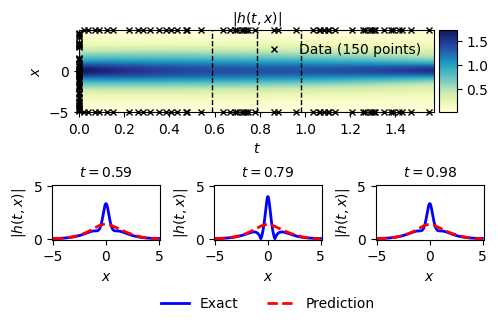

In [36]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/3_sine')

##### FINER

![](finer.png)

In [37]:
net_finer = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="FINER",  # use registry
                            activation_kwargs={'omega':5},  # extra params
                            initializer="FINER",  # use registry
                            initializer_kwargs={'omega':5, 'k':0.5},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [38]:
model = pinnstorch.models.PINNModule(net = net_finer,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [39]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = num_epochs)
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modu

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, v_num=87, train/loss_step=20.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s, v_num=87, train/loss_step=10.30, val/loss=1.170, val/error_u=0.870, val/error_v=0.984, val/error_h=0.793, val/loss_best=1.170, train/loss_epoch=20.00]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s, v_num=87, train/loss_step=6.170, val/loss=1.170, val/error_u=0.860, val/error_v=0.992, val/error_h=0.791, val/loss_best=1.170, train/loss_epoch=10.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s, v_num=87, train/loss_step=4.180, val/loss=1.150, val/error_u=0.850, val/error_v=1.000, val/error_h=0.781, val/loss_best=1.150, train/loss_epoch=6.170]
Validation: |     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s, v_num=87, train/loss_step=0.0894, val/loss=0.849, val/error_u=0.814, val/error_v=1.080, val/error_h=0.457, val/loss_best=0.842, train/loss_epoch=0.0894]


In [40]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 12.685589075088501s


In [41]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.4565119445323944     │
│        val/error_u        │     0.814345121383667     │
│        val/error_v        │    1.0793018341064453     │
│         val/loss          │    0.8490786552429199     │
│       val/loss_best       │     0.842156171798706     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.8490786552429199,
  'val/error_u': 0.814345121383667,
  'val/error_v': 1.0793018341064453,
  'val/error_h': 0.4565119445323944,
  'val/loss_best': 0.842156171798706}]

In [42]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.72it/s] 


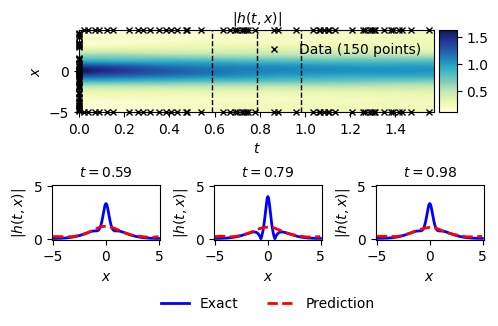

In [43]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/4_finer')

##### GAUSSIAN

![](gaussian.png)

In [44]:
net_gaussian = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="GAUSSIAN",  # use registry
                            activation_kwargs={'sigma':5},  # extra params
                            initializer="XAVIER_UNIFORM",  # use registry
                            initializer_kwargs={},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )


In [45]:
model = pinnstorch.models.PINNModule(net = net_gaussian,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [46]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = num_epochs)
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modu

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.76it/s, v_num=88, train/loss_step=68.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, v_num=88, train/loss_step=51.90, val/loss=1.300, val/error_u=0.869, val/error_v=1.140, val/error_h=0.818, val/loss_best=1.300, train/loss_epoch=68.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s, v_num=88, train/loss_step=41.60, val/loss=1.340, val/error_u=0.927, val/error_v=1.090, val/error_h=0.831, val/loss_best=1.300, train/loss_epoch=51.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=88, train/loss_step=32.50, val/loss=1.270, val/error_u=0.944, val/error_v=1.070, val/error_h=0.772, val/loss_best=1.270, train/loss_epoch=41.60]
Validation: |     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s, v_num=88, train/loss_step=0.371, val/loss=0.899, val/error_u=0.830, val/error_v=0.989, val/error_h=0.570, val/loss_best=0.899, train/loss_epoch=0.371]


In [47]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 12.373274087905884s


In [48]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.5699012875556946     │
│        val/error_u        │     0.830480694770813     │
│        val/error_v        │    0.9892342686653137     │
│         val/loss          │    0.8989710211753845     │
│       val/loss_best       │    0.8989710211753845     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.8989710211753845,
  'val/error_u': 0.830480694770813,
  'val/error_v': 0.9892342686653137,
  'val/error_h': 0.5699012875556946,
  'val/loss_best': 0.8989710211753845}]

In [49]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.47it/s] 


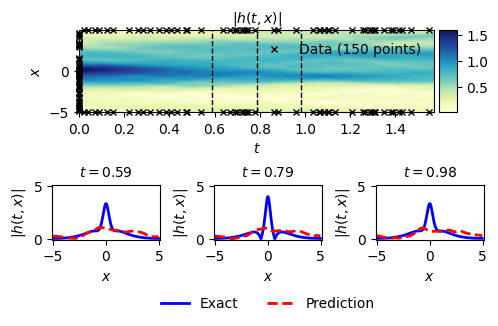

In [50]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/5_gaussian')

##### GAUSSIAN W/ FINER

In [51]:
net_gaussian_finer = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="GAUSSIAN_FINER",  # use registry
                            activation_kwargs={'sigma':10, 'omega':20},  # extra params
                            initializer="XAVIER_UNIFORM_FINER",  # use registry
                            initializer_kwargs={'k':1},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )


In [52]:
model = pinnstorch.models.PINNModule(net = net_gaussian_finer,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [53]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = num_epochs)
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modu

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.95it/s, v_num=89, train/loss_step=3.65e+11]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  0.31it/s, v_num=89, train/loss_step=4.04e+11, val/loss=1.630, val/error_u=0.965, val/error_v=1.480, val/error_h=0.797, val/loss_best=1.630, train/loss_epoch=3.65e+11]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, v_num=89, train/loss_step=4.12e+11, val/loss=1.630, val/error_u=0.965, val/error_v=1.470, val/error_h=0.796, val/loss_best=1.630, train/loss_epoch=4.04e+11]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s, v_num=89, train/loss_step=4.2e+11, val/loss=1.620, val/error_u=0.966, val/error_v=1.470, val/error_h=0.795, val/loss_best=1.620, train/loss_epoch=4.12e+11

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s, v_num=89, train/loss_step=7.33e+10, val/loss=1.330, val/error_u=0.887, val/error_v=1.240, val/error_h=0.763, val/loss_best=1.330, train/loss_epoch=7.33e+10]


In [54]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 15.147070169448853s


In [55]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.7630326747894287     │
│        val/error_u        │    0.8872917294502258     │
│        val/error_v        │     1.244020700454712     │
│         val/loss          │     1.325675368309021     │
│       val/loss_best       │     1.325675368309021     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 1.325675368309021,
  'val/error_u': 0.8872917294502258,
  'val/error_v': 1.244020700454712,
  'val/error_h': 0.7630326747894287,
  'val/loss_best': 1.325675368309021}]

In [56]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s] 


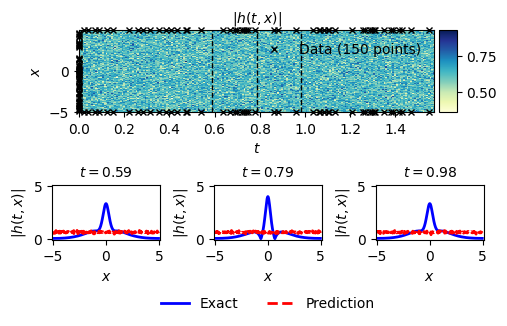

In [57]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/6_gaussian_finer')

##### HYPERBOLIC SINE

![](hosc.png)
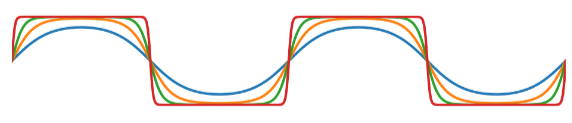

In [58]:
net_hosc = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="HOSC",  # use registry
                            activation_kwargs={'beta':5},  # extra params
                            initializer="XAVIER_UNIFORM",  # use registry
                            initializer_kwargs={},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [59]:
model = pinnstorch.models.PINNModule(net = net_hosc,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [60]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = num_epochs)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [61]:
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.70it/s, v_num=90, train/loss_step=263.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, v_num=90, train/loss_step=27.10, val/loss=2.920, val/error_u=1.570, val/error_v=1.590, val/error_h=1.080, val/loss_best=2.920, train/loss_epoch=263.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=90, train/loss_step=39.50, val/loss=4.090, val/error_u=1.610, val/error_v=2.410, val/error_h=1.140, val/loss_best=2.920, train/loss_epoch=27.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s, v_num=90, train/loss_step=26.40, val/loss=4.250, val/error_u=1.650, val/error_v=2.530, val/error_h=1.090, val/loss_best=2.920, train/loss_epoch=39.50]
Validation: |     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, v_num=90, train/loss_step=0.386, val/loss=0.954, val/error_u=0.794, val/error_v=0.946, val/error_h=0.679, val/loss_best=0.954, train/loss_epoch=0.386]


In [62]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 18.06877040863037s


In [63]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.6793492436408997     │
│        val/error_u        │     0.793968915939331     │
│        val/error_v        │    0.9464600682258606     │
│         val/loss          │    0.9537883996963501     │
│       val/loss_best       │    0.9537883996963501     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 0.9537883996963501,
  'val/error_u': 0.793968915939331,
  'val/error_v': 0.9464600682258606,
  'val/error_h': 0.6793492436408997,
  'val/loss_best': 0.9537883996963501}]

In [64]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.67it/s]


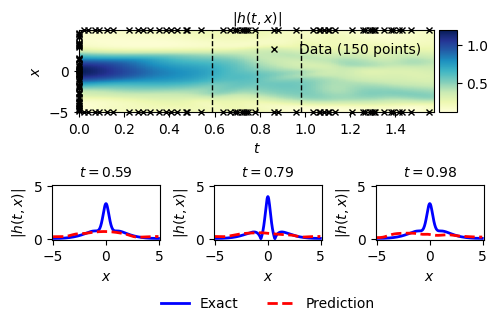

In [65]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/7_hosc')

##### HYPERBOLIC SINE W/ FINER

In [66]:
net_hosc_finer = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="HOSC_FINER",  # use registry
                            activation_kwargs={'beta':5, 'omega':0.5},  # extra params
                            initializer="XAVIER_UNIFORM_FINER",  # use registry
                            initializer_kwargs={'k':1},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [67]:
model = pinnstorch.models.PINNModule(net = net_hosc_finer,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')


In [68]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = num_epochs)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [69]:
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\micke\anaconda3\envs\myenv\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


Epoch 0: 100%|██████████| 1/1 [00:01<00:00,  0.88it/s, v_num=91, train/loss_step=527.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:03<00:00,  0.29it/s, v_num=91, train/loss_step=393.0, val/loss=2.880, val/error_u=1.480, val/error_v=1.570, val/error_h=1.140, val/loss_best=2.880, train/loss_epoch=527.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, v_num=91, train/loss_step=396.0, val/loss=3.510, val/error_u=1.490, val/error_v=1.930, val/error_h=1.270, val/loss_best=2.880, train/loss_epoch=393.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s, v_num=91, train/loss_step=261.0, val/loss=2.790, val/error_u=1.730, val/error_v=1.430, val/error_h=0.924, val/loss_best=2.790, train/loss_epoch=396.0]
Validation: |     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, v_num=91, train/loss_step=1.520, val/loss=1.110, val/error_u=0.883, val/error_v=1.020, val/error_h=0.719, val/loss_best=1.110, train/loss_epoch=1.520]


In [70]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 16.82309889793396s


In [71]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │    0.7192818522453308     │
│        val/error_u        │     0.883100688457489     │
│        val/error_v        │    1.0162047147750854     │
│         val/loss          │    1.1142255067825317     │
│       val/loss_best       │    1.1142255067825317     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 1.1142255067825317,
  'val/error_u': 0.883100688457489,
  'val/error_v': 1.0162047147750854,
  'val/error_h': 0.7192818522453308,
  'val/loss_best': 1.1142255067825317}]

In [72]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.62it/s]


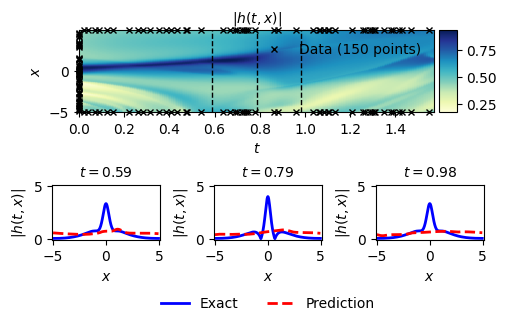

In [73]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/8_hosc_finer')

##### SINC

![](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/01/sinc-function.png?resize=543%2C311&ssl=1)

In [219]:
net_sinc = pinnstorch.models.FCN(layers=layers,
                            output_names=['u', 'v'],
                            lb=mesh.lb,
                            ub=mesh.ub,
                            activation="SINC",  # use registry
                            activation_kwargs={'omega':1},  # extra params
                            initializer="XAVIER_UNIFORM_FINER",  # use registry
                            initializer_kwargs={'k':1},  # extra params
                            layer_type='BASE',
                            layer_kwargs={}
                            )

In [220]:
model = pinnstorch.models.PINNModule(net = net_sinc,
                                     pde_fn = pde_fn,
                                     output_fn = output_fn,
                                     loss_fn = 'mse')

In [221]:
trainer = pl.Trainer(accelerator='auto', devices=1, max_epochs = 20)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [222]:
start_time = time.time()

trainer.fit(model=model, datamodule=datamodule)
end_time = time.time()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | net           | FCN        | 30.8 K | train
1 | train_loss    | MeanMetric | 0      | train
2 | val_loss      | MeanMetric | 0      | train
3 | val_error     | MeanMetric | 0      | train
4 | test_loss     | MeanMetric | 0      | train
5 | test_error    | MeanMetric | 0      | train
6 | val_loss_best | MinMetric  | 0      | train
-----------------------------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, v_num=114, train/loss_step=29.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s, v_num=114, train/loss_step=2.170, val/loss=1.420, val/error_u=0.982, val/error_v=1.200, val/error_h=0.796, val/loss_best=1.420, train/loss_epoch=29.60]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s, v_num=114, train/loss_step=3.640, val/loss=1.790, val/error_u=1.170, val/error_v=1.200, val/error_h=0.920, val/loss_best=1.420, train/loss_epoch=2.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s, v_num=114, train/loss_step=6.290, val/loss=2.340, val/error_u=1.510, val/error_v=1.010, val/error_h=1.060, val/loss_best=1.420, train/loss_epoch=3.640]
Validation: | 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s, v_num=114, train/loss_step=nan.0, val/loss=nan.0, val/error_u=nan.0, val/error_v=nan.0, val/error_h=nan.0, val/loss_best=1.420, train/loss_epoch=nan.0]


In [218]:
total_time = end_time - start_time
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Training time: {hours}h {minutes}m {seconds}s")

Training time: 0.0h 0.0m 2.7911741733551025s


In [211]:
trainer.validate(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        val/error_h        │            nan            │
│        val/error_u        │            nan            │
│        val/error_v        │            nan            │
│         val/loss          │            nan            │
│       val/loss_best       │    1.1740764379501343     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': nan,
  'val/error_u': nan,
  'val/error_v': nan,
  'val/error_h': nan,
  'val/loss_best': 1.1740764379501343}]

In [212]:
preds_list = trainer.predict(model=model, datamodule=datamodule)
preds_dict = pinnstorch.utils.fix_predictions(preds_list)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.17it/s]


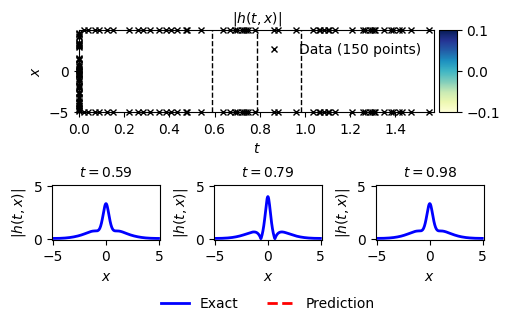

In [213]:
pinnstorch.utils.plot_schrodinger(mesh=mesh,
                                  preds=preds_dict,
                                  train_datasets=train_datasets,
                                  val_dataset=val_dataset,
                                  file_name='out/9_sinc')